In [36]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Looking at the system we loaded

One of the first things to do when loading a system is to inspect the data.
This is useful to check that we have loaded the correct data, and that the data is as expected.

In [77]:
u = mda.Universe('./single_system.pdb', 'traj_unwrapped.xtc')

In [78]:
# Q: how many atoms are in the box?
# A  len(u.atoms)
# Q: what residues are present in the box?
# A: set(u.atoms.resnames)
# Q: how many bonds are in the system?
# A: len(u.bonds)
# Q: how many bonds would you expect in the system?
# A: Probably about ~4000?

In [79]:
len(u.bonds)

45

Our system seems correct, but the number of bonds seems low...
Let's try and figure out what went wrong.

In [81]:
# Selecting components of the system
protein = u.select_atoms('protein')
ligand = u.select_atoms('resname UNK')
ions = u.select_atoms('resname NA CL')

In [82]:
# Q: How would you verify that these three atom groups contain all of the atoms contained within u.atoms
# A: Could use set operations to subtract from u.atoms, e.g.:
u.atoms - (protein + ligand + ions)

<AtomGroup with 0 atoms>

Q: How would we check the number of bonds in each of these different components of the system?

A: `len(protein.bonds)` etc

In [83]:
# Q: how could you guess the bonds within an AtomGroup?
u.select_atoms('protein').guess_bonds()

In [84]:
# Q: given the number of ions, approximately how many bonds should you expect?
# Q: the ligand has 32 atoms, based on the number of bonds, can you tell how many rings are in the ligand molecule?
# a: Would normally expect n_bonds = (n_atoms - 1) for system without rings
#    each ring "adds" a bond, i.e. n_bonds = (n_atoms - 1) + n_rings
#    so n_rings = n_bonds - (n_atoms - 1)
len(ligand.bonds) - (len(ligand.atoms) - 1)

2

In [85]:
# Q: (hard) given the number of molecules and bonds in the entire system, how many rings are there in this system?
# A: Each molecule adds an atom without an expected bond, so
#    n_bonds = (n_atoms - 1) + n_rings - n_molecules

## Periodic boundaries and minimising distances

Periodic boundary conditions allow for an approximation of an infinitely sized system by simulating a simple unit cell. This is illustrated below. The black box is the only cell we simulate; the tiled images around it are there for illustration. The green particle moves past the top boundary of the unit cell and are moved to the bottom of the box with the same velocity (illustrated by the red dashed line). This boundary condition keeps the volume and number of particles constant in the simulation.


<a href="https://upload.wikimedia.org/wikipedia/commons/2/2e/Limiteperiodicite.svg">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/2e/Limiteperiodicite.svg" width="400"/a>

### Questions

Q: In a cubic box with box length L, what is the largest possible distance you can travel in a single dimension before wrapping back around on yourself?

A: L.  i.e. once you have travelled L in any single direction you are back to where you started.

Q: In a cubic box with length L, what is the largest possible separation between two objects along a single dimension?

A: L/2, any larger and there would be a smaller separation vector in the opposite direction.

Q: As above, but what is the largest possible separation for a 3 dimensional vector?

A: L/2 * sqrt(3)

In each dimension largest separation is L/2.
2D vector is sqrt(L^2/4 + L^2/4) = sqrt(L^2 / 2)
Then 3D is sqrt(L^2 / 2 + L^2 / 4) = sqrt(L^2 * 3/4) = L/2 sqrt(3)

### Advanced Questions

Q: In a rectangular box with sides [Lx, Ly, Lz] how do the above answers change?

Q: In a skewed triclinic box, how do the above answers change?

## Boxes in MDAnalysis

The information on the periodic box is stored in the `Universe.dimensions` or `AtomGroup.dimensions` attribute.
This gives a description of the box as 6 values, the length in x, y, z dimensions and the angle between the three vectors.
For our example today:

In [63]:
print(f'Our box is {u.dimensions}')

Our box is [82.06851 82.06851 82.06851 90.      90.      90.     ]


All angles between the vectors are 90 degrees, so the box is orthorhombic (rectangular).
Also the length of each dimension is identical, so we actually happen to have a cubic box.

In [64]:
box_L = u.dimensions[0]
print(box_L)

82.06851


## The `minimize_vectors` function

The `MDAnalysis.lib.distances.minimize_vectors` function will take an array (or single) 3D vector and box description and return the smallest version of these vectors (or vector).


Q: What is the expected return for minimize_vectors([L, L, L], u.dimensions) ?

A: [0, 0, 0], since each vector gets minimised to 0

Q: What is the expected return for minimize_vectors([1.2 * L, 0.2 L, 0.2 L], u.dimensions) ?

A: [0.2L, 0.2L, 0.2L]

Q As above, for [0.6L, 0.2L, 0.2L]

A: [-0.4L, 0.2L, 0.2L].  The 0.6L can be made shorter by subtracting a box length from that dimension.

Q: If the vector was the separation between two molecules, what does the **difference** between the original and minimised vector represent?

A: The vector along which you can translate a molecule to minimise its **apparent** distance to another molecule.  I.e. it moves the molecule into the same image.

Q: If I translate a molecule by an entire box vector(s) in a given direction(s)f, has the molecule moved?

A: Depends.  Within a frame this does not represent a different position.  Over the course of a trajectory a molecule might diffuse for an entire box length, in which case yes it has moved.

In [86]:
mda.lib.distances.minimize_vectors(np.array([box_L, box_L, box_L]), u.dimensions)

array([0., 0., 0.], dtype=float32)

Have an experiment with the above example questions using the minimize_vectors function

In [87]:
mda.lib.distances.minimize_vectors(np.array([0.6 * box_L, 0.2 * box_L, 0.2 * box_L]), u.dimensions) / box_L

array([-0.4,  0.2,  0.2])

## Checking the position of our ligand relative to the protein.

In our simulation we are expecting that the ligand molecule should stay close to its original position.
As a very simple check of our simulation we want to check the position of the ligand molecule relative to the protein molecule.  This will tell us if our simulation went as expected, or if the ligand was unhappy in its starting position and moved away.

In [ ]:
## Guide for how to solve the above question step by step?
# For a single frame

# Q: How do we get the center of mass of an AtomGroup?

# Q: How do we find the distance between two coordinates (i.e. centers of mass)

In [ ]:
# Q: Building this up, how would we iterate over a trajectory and calculate this for each frame?

# Q: How would we allocate an array to store these distances and store each frame in this array?

In [14]:
distance = np.zeros(len(u.trajectory))
for ts in u.trajectory:
    sep = protein.center_of_mass() - ligand.center_of_mass()

    distance[ts.frame] = np.linalg.norm(sep)

    # or alternatively
    # distance[ts.frame] = mda.lib.distances.calc_bonds(protein.center_of_mass(), ligand.center_of_mass(), box=None)
    # box=None ignores periodic boundary condition considerations, which is what visualising the trajectory does

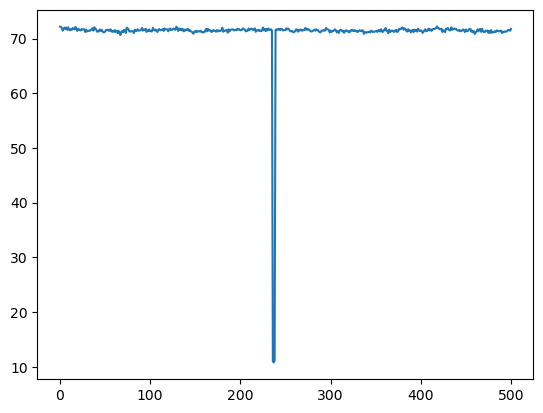

In [15]:
fig, ax = plt.subplots()

ax.plot(distance)

## Co-locating the ligand and protein

In [9]:
protein.center_of_mass()

array([70.48313699,  1.32447797, 66.42303709])

In [10]:
ligand.center_of_mass()

array([75.05613137, 73.33579275, 64.85428082])

In [88]:
# Q: calculate the vector separating the protein COM from ligand COM
# a: 
separation = protein.center_of_mass() - ligand.center_of_mass()

In [89]:
# Q: u.dimensions gives the box dimensions as [Lx, Ly, Lz, alpha, beta, gamma], what shape is the system periodic box?
# a: orthorhombic box
# Q: how is it permitted to translate coordinates of the ligand molecule while respecting periodic boundary conditions
# a: can translate ligand molecule by any of the box vectors Lx, Ly, Lz (or combinations thereof)

In [90]:
minimal_separation = mda.lib.distances.minimize_vectors(separation, box=u.dimensions)

In [91]:
separation - minimal_separation

array([ 0.00000000e+00, -8.20685120e+01, -2.22044605e-16])

In [92]:
(separation - minimal_separation) / box_L

array([ 0.00000000e+00, -1.00000000e+00, -2.70560047e-18])

In [18]:
ligand.translate(separation - minimal_separation)

<AtomGroup with 32 atoms>

In [19]:
protein.center_of_mass() - ligand.center_of_mass()

array([-4.57299437, 10.05719719,  1.56875628])

## Writing a function to shift the ligand to the closest image to the protein



In [20]:
# Q: which periodic image of the ligand is correct?
# a: trick question, all images are correct, depending on the calculation
#    for looking at ligand interaction with protein, likely the one that minimises COM distance is correct

## Putting it all together

MDAnalysis contains a system for automatically applying these sorts of post-simulation modifications to trajectories called `transformations`.
These are one or more functions which alter the trajectory data just after it is loaded,
and are applied automatically whenever the trajectory is manipulated (i.e. iterated or seeked etc).

We can write our own `Transformation` objects to apply the ligand re-imaging automatically.
To do this we must import the `TransformationBase` class, and create a subclass which we will call `LigandShift`.

There are two methods (functions on the class) that we must write.
First the `__init__` method defines what information the transformation requires to operate,
in our case this is the definition of the protein and ligand AtomGroups.
Next the `._transform` method defines the mathematical operations that will take place which will operate on these two AtomGroups.

Using the previously written functions, finish the `LigandShift` transformation class.

In [73]:
from MDAnalysis.transformations.base import TransformationBase

class LigandShift(TransformationBase):
    def __init__(self, protein, ligand):
        super().__init__()
        self.protein = protein
        self.ligand = ligand

    def _transform(self, ts):
        # put ligand shifting code here
        
        return ts

In [93]:
u2 = mda.Universe('./single_system.pdb', './traj_unwrapped.xtc')

prot2 = u2.select_atoms('protein')
ligand2 = u2.select_atoms('resname UNK')

In [94]:
ligshift = LigandShift(prot2, ligand2)

In [95]:
u2.trajectory.add_transformations(ligshift)

In [ ]:
# run the above analysis wrt ligand-protein position
# and check that the transformation pipeline has properly post-processed your trajectory data

## Extension work

Using the previous notebooks on using Analysis modules, calculate the RMSD and RMSF of the ligand molecule.
Does this differ when using the above transformation toolchain?

Another common operation is to align the trajectory to minimise the RMSD of the protein over the trajectory.  How could this be implemented as a transformation?